In [19]:
import time
import pandas as pd
import json
from datetime import datetime
from datetime import timezone


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go
from plotly.subplots import make_subplots

## DMP Class

In [20]:
from pydmps.dmp import DMPs


class DMPs_rhythmic(DMPs):
    """An implementation of discrete DMPs"""

    def __init__(self, **kwargs):
        """
        """

        # call super class constructor
        super(DMPs_rhythmic, self).__init__(pattern="rhythmic", **kwargs)

        self.gen_centers()

        # set variance of Gaussian basis functions
        # trial and error to find this spacing
        self.h = np.ones(self.n_bfs) * self.n_bfs  # 1.75

        self.check_offset()

    def gen_centers(self):
        """Set the centre of the Gaussian basis
        functions be spaced evenly throughout run time"""

        c = np.linspace(0, 2 * np.pi, self.n_bfs + 1)
        c = c[0:-1]
        self.c = c

    def gen_front_term(self, x, dmp_num):
        """Generates the front term on the forcing term.
        For rhythmic DMPs it's non-diminishing, so this
        function is just a placeholder to return 1.

        x float: the current value of the canonical system
        dmp_num int: the index of the current dmp
        """

        if isinstance(x, np.ndarray):
            return np.ones(x.shape)
        return 1

    def gen_goal(self, y_des):
        """Generate the goal for path imitation.
        For rhythmic DMPs the goal is the average of the
        desired trajectory.

        y_des np.array: the desired trajectory to follow
        """

        goal = np.zeros(self.n_dmps)
        for n in range(self.n_dmps):
            num_idx = ~np.isnan(y_des[n])  # ignore nan's when calculating goal
            goal[n] = 0.5 * (y_des[n, num_idx].min() + y_des[n, num_idx].max())

        return goal

    def gen_psi(self, x):
        """Generates the activity of the basis functions for a given
        canonical system state or path.

        x float, array: the canonical system state or path
        """

        if isinstance(x, np.ndarray):
            x = x[:, None]
        return np.exp(self.h * (np.cos(x - self.c) - 1))

    def gen_weights(self, f_target):
        """Generate a set of weights over the basis functions such
        that the target forcing term trajectory is matched.

        f_target np.array: the desired forcing term trajectory
        """

        # calculate x and psi
        x_track = self.cs.rollout()
        psi_track = self.gen_psi(x_track)

        # efficiently calculate BF weights using weighted linear regression
        for d in range(self.n_dmps):
            for b in range(self.n_bfs):
                self.w[d, b] = np.dot(psi_track[:, b], f_target[:, d]) / (
                    np.sum(psi_track[:, b]) + 1e-10
                )


In [21]:

class DMPs_discrete(DMPs):
    """An implementation of discrete DMPs"""

    def __init__(self, **kwargs):
        """
        """

        # call super class constructor
        super(DMPs_discrete, self).__init__(pattern='discrete', **kwargs)

        self.gen_centers()

        # set variance of Gaussian basis functions
        # trial and error to find this spacing
        self.h = np.ones(self.n_bfs) * self.n_bfs**1.5 / self.c / self.cs.ax

        self.check_offset()

    def gen_centers(self):
        """Set the centre of the Gaussian basis
        functions be spaced evenly throughout run time"""

        '''x_track = self.cs.discrete_rollout()
        t = np.arange(len(x_track))*self.dt
        # choose the points in time we'd like centers to be at
        c_des = np.linspace(0, self.cs.run_time, self.n_bfs)
        self.c = np.zeros(len(c_des))
        for ii, point in enumerate(c_des):
            diff = abs(t - point)
            self.c[ii] = x_track[np.where(diff == min(diff))[0][0]]'''

        # desired activations throughout time
        des_c = np.linspace(0, self.cs.run_time, self.n_bfs)

        self.c = np.ones(len(des_c))
        for n in range(len(des_c)):
            # finding x for desired times t
            self.c[n] = np.exp(-self.cs.ax * des_c[n])

    def gen_front_term(self, x, dmp_num):
        """Generates the diminishing front term on
        the forcing term.

        x float: the current value of the canonical system
        dmp_num int: the index of the current dmp
        """
        return x * (self.goal[dmp_num] - self.y0[dmp_num])

    def gen_goal(self, y_des):
        """Generate the goal for path imitation.
        For rhythmic DMPs the goal is the average of the
        desired trajectory.

        y_des np.array: the desired trajectory to follow
        """

        return np.copy(y_des[:, -1])

    def gen_psi(self, x):
        """Generates the activity of the basis functions for a given
        canonical system rollout.

        x float, array: the canonical system state or path
        """

        if isinstance(x, np.ndarray):
            x = x[:, None]
        return np.exp(-self.h * (x - self.c)**2)

    def gen_weights(self, f_target):
        """Generate a set of weights over the basis functions such
        that the target forcing term trajectory is matched.

        f_target np.array: the desired forcing term trajectory
        """

        # calculate x and psi
        x_track = self.cs.rollout()
        psi_track = self.gen_psi(x_track)

        # efficiently calculate BF weights using weighted linear regression
        self.w = np.zeros((self.n_dmps, self.n_bfs))
        for d in range(self.n_dmps):
            # spatial scaling term
            k = (self.goal[d] - self.y0[d])
            for b in range(self.n_bfs):
                numer = np.sum(x_track * psi_track[:, b] * f_target[:, d])
                denom = np.sum(x_track**2 * psi_track[:, b])
                self.w[d, b] = numer / (k * denom)
        self.w = np.nan_to_num(self.w)

# Code

In [22]:
def read_json_from_ros2bag(json_file, print_ = True):
    list_of_length = []
    with open(json_file, 'r') as file:
        json_content = json.load(file)
    if print_:
        print('Read: ',json_file)
    for key, value in json_content.items():
        if print_:
            print(f"{key} range: {len(value)}")
        list_of_length.append(len(value))
    cut_data = {key: value[:min(list_of_length)] for key, value in json_content.items()}
    cut_df = pd.DataFrame(cut_data)
    return cut_df
def read_and_normalize_json_from_ros2bag(json_file, print_=True):
    list_of_length = []
    with open(json_file, 'r') as f:
        data = json.load(f)
    if print_:
        print('Read: ',json_file)
    for key, value in data.items():
        if print_:
            print(f"{key} range: {len(value)}")
        list_of_length.append(len(value))
    # Normalize the data into a DataFrame
    df = pd.json_normalize(data)
    return df

def process_sensor_data(input_df, sensor_key, output_column, window_slide=1, shift=0):
    sensor_val = []
    sensor_ts = []
    sensor_df = []

    for i in range(len(input_df[sensor_key][0])):
        sensor_val.append(input_df[sensor_key][0][i]['val'])
        sensor_ts.append(input_df[sensor_key][0][i]['ts'])

    sensor_df = pd.DataFrame(sensor_val, columns=output_column)
    sensor_df = sensor_df.shift(shift)
    sensor_df = sensor_df.rolling(window=window_slide).mean()
    sensor_df['ts'] = sensor_ts

    return sensor_df

In [78]:
df        = read_and_normalize_json_from_ros2bag('stair/subject2_OAIC_S1_Stair_1.json', print_=False)

shift = 0

window_slide = 100
stair_joint_cmd_df = process_sensor_data(df, 'JointCmd',        ['RH','RK','RA','LH','LK','LA'], window_slide, shift)
stair_joint_fb_df  = process_sensor_data(df, 'JointAngles',        ['RH','RK','RA','LH','LK','LA'], window_slide, shift)
stair_foot_force_df = process_sensor_data(df, 'FootPressure',        ['Rheel','Rtoe','Lheel','Ltoe'], window_slide, shift)

In [163]:
df        = read_and_normalize_json_from_ros2bag('symmetrical_walk/subject_1/subject1_OAIC_S38_4.json', print_=False)

shift = 0

window_slide = 1
sym_joint_cmd_df = process_sensor_data(df, 'GaitStep',        ['RH','RK','RA','LH','LK','LA'], window_slide, shift)
sym_joint_fb_df  = process_sensor_data(df, 'JointAngles',        ['RH','RK','RA','LH','LK','LA'], window_slide, shift)
sym_foot_force_df = process_sensor_data(df, 'FootPressure',        ['Rheel','Rtoe','Lheel','Ltoe'], window_slide, shift)

## Plot Sample

(-5.0, 400.0)

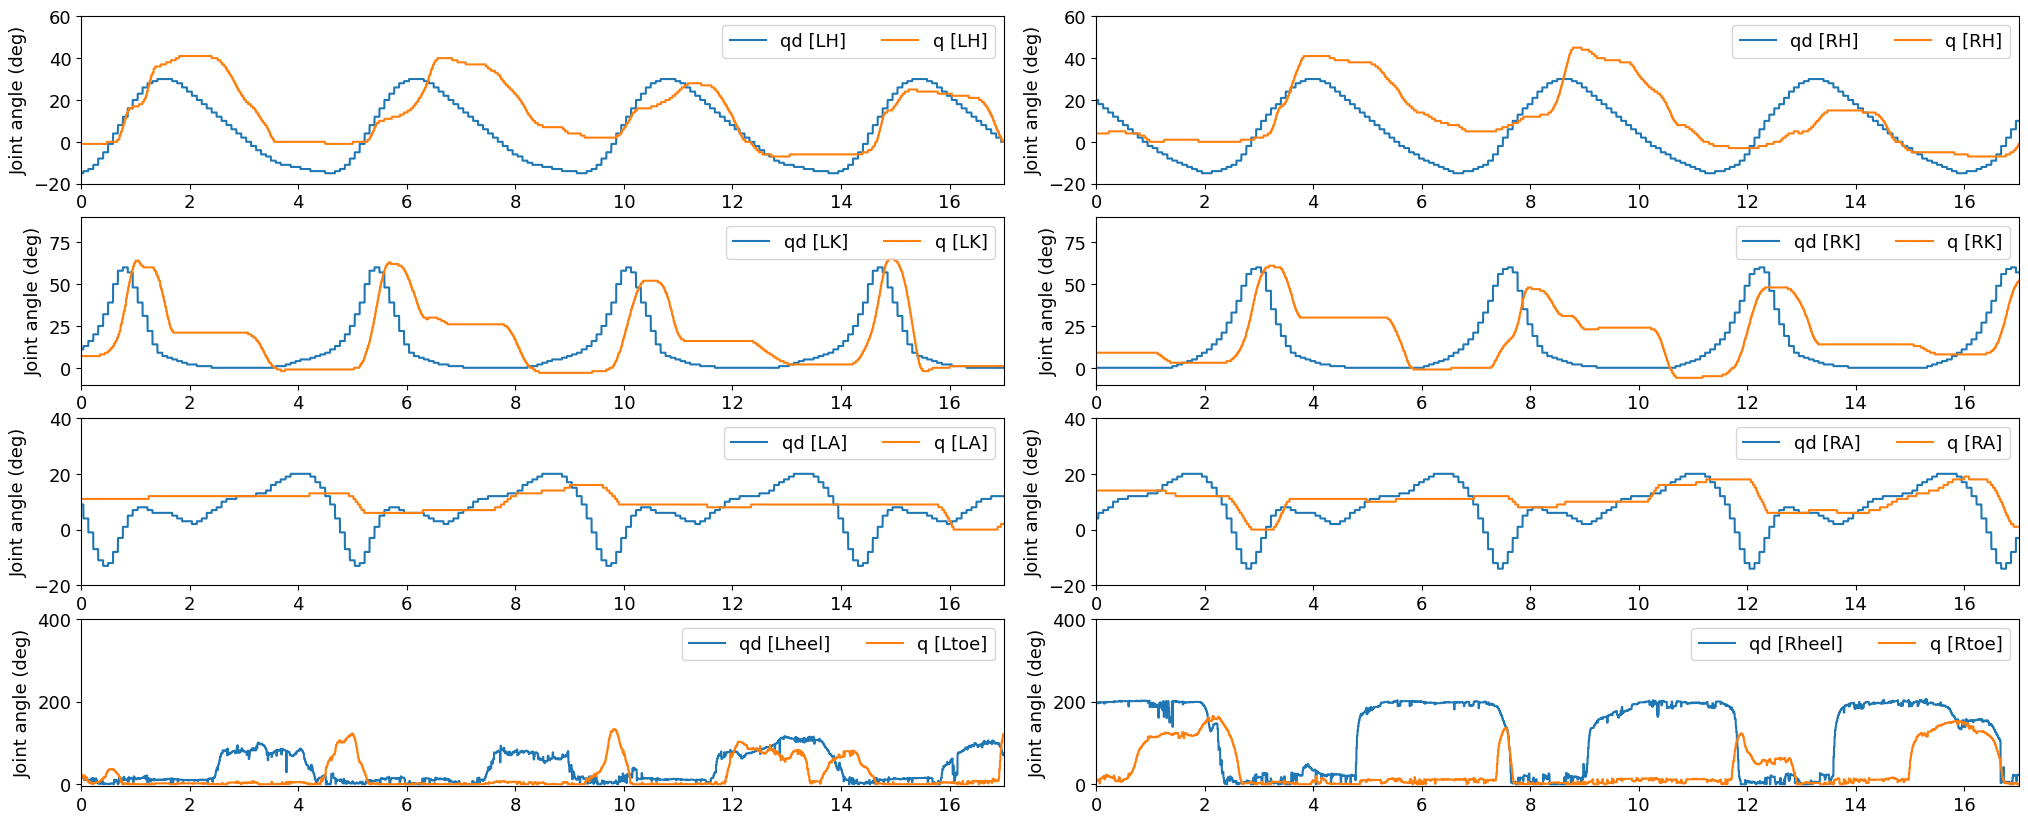

In [ ]:
# import matplotlib.pyplot as plt
# plt.rcParams['font.size'] = 13
# plt.rcParams['xtick.labelsize'] = 13 
# plt.rcParams['ytick.labelsize'] = 13 
# class ScalarFormatterClass(ScalarFormatter):
#    def _set_format(self):
#       self.format = "%1.2f"

# row_num = 4
# col_num = 2
# fig, ax = plt.subplots(row_num, col_num, sharey=False, gridspec_kw={ 'wspace':0.1, 'hspace':0.2}, figsize=(25, 10))

# time_period = 17
# # ===========================================
# #                 
# # ===========================================

# ax[0,1].plot(np.array(stair_joint_cmd_df['ts']), np.array(stair_joint_cmd_df['RH']), label='qd [RH]')
# ax[0,1].plot(np.array(stair_joint_fb_df['ts']), np.array(stair_joint_fb_df['RH']), label='q [RH]')
# ax[0,1].set_ylabel('Joint angle (deg)')
# ax[0,1].legend(ncol=11, loc='upper right')
# ax[0,1].set_xlim(0, time_period)
# ax[0,1].set_ylim(-20, 60)
# # ===========================================
# #                 
# # ===========================================
# ax[1,1].plot(np.array(stair_joint_cmd_df['ts']), np.array(stair_joint_cmd_df['RK']), label='qd [RK]')
# ax[1,1].plot(np.array(stair_joint_fb_df['ts']), np.array(stair_joint_fb_df['RK']), label='q [RK]')
# ax[1,1].set_ylabel('Joint angle (deg)')
# ax[1,1].legend(ncol=11, loc='upper right')
# ax[1,1].set_xlim(0, time_period)
# ax[1,1].set_ylim(-10, 90)

# # ===========================================
# #                 
# # ===========================================

# ax[2,1].plot(np.array(stair_joint_cmd_df['ts']), np.array(stair_joint_cmd_df['RA']), label='qd [RA]')
# ax[2,1].plot(np.array(stair_joint_fb_df['ts']), np.array(stair_joint_fb_df['RA']), label='q [RA]')
# ax[2,1].set_ylabel('Joint angle (deg)')
# ax[2,1].legend(ncol=11, loc='upper right')
# ax[2,1].set_xlim(0, time_period)
# ax[2,1].set_ylim(-20, 40)

# # ===========================================
# #                 
# # ===========================================

# ax[0,0].plot(np.array(stair_joint_cmd_df['ts']), np.array(stair_joint_cmd_df['LH']), label='qd [LH]')
# ax[0,0].plot(np.array(stair_joint_fb_df['ts']), np.array(stair_joint_fb_df['LH']), label='q [LH]')
# ax[0,0].set_ylabel('Joint angle (deg)')
# ax[0,0].legend(ncol=11, loc='upper right')
# ax[0,0].set_xlim(0, time_period)
# ax[0,0].set_ylim(-20, 60)

# # ===========================================
# #                 
# # ===========================================

# ax[1,0].plot(np.array(stair_joint_cmd_df['ts']), np.array(stair_joint_cmd_df['LK']), label='qd [LK]')
# ax[1,0].plot(np.array(stair_joint_fb_df['ts']), np.array(stair_joint_fb_df['LK']), label='q [LK]')
# ax[1,0].set_ylabel('Joint angle (deg)')
# ax[1,0].legend(ncol=11, loc='upper right')
# ax[1,0].set_xlim(0, time_period)
# ax[1,0].set_ylim(-10, 90)

# # ===========================================
# #                 
# # ===========================================
# ax[2,0].plot(np.array(stair_joint_cmd_df['ts']), np.array(stair_joint_cmd_df['LA']), label='qd [LA]')
# ax[2,0].plot(np.array(stair_joint_fb_df['ts']), np.array(stair_joint_fb_df['LA']), label='q [LA]')
# ax[2,0].set_ylabel('Joint angle (deg)')
# ax[2,0].legend(ncol=11, loc='upper right')
# ax[2,0].set_xlim(0, time_period)
# ax[2,0].set_ylim(-20, 40)

# # ===========================================
# #                 
# # ===========================================
# ax[3,1].plot(np.array(stair_foot_force_df['ts']), np.array(stair_foot_force_df['Rheel']), label='qd [Rheel]')
# ax[3,1].plot(np.array(stair_foot_force_df['ts']), np.array(stair_foot_force_df['Rtoe']),  label='q [Rtoe]')
# ax[3,1].set_ylabel('Joint angle (deg)')
# ax[3,1].legend(ncol=11, loc='upper right')
# ax[3,1].set_xlim(0, time_period)
# ax[3,1].set_ylim(-5, 400)

# # ===========================================
# #                 
# # ===========================================
# ax[3,0].plot(np.array(stair_foot_force_df['ts']), np.array(stair_foot_force_df['Lheel']), label='qd [Lheel]')
# ax[3,0].plot(np.array(stair_foot_force_df['ts']), np.array(stair_foot_force_df['Ltoe']), label='q [Ltoe]')
# ax[3,0].set_ylabel('Joint angle (deg)')
# ax[3,0].legend(ncol=11, loc='upper right')
# ax[3,0].set_xlim(0, time_period)
# ax[3,0].set_ylim(-5, 400)



(-5.0, 400.0)

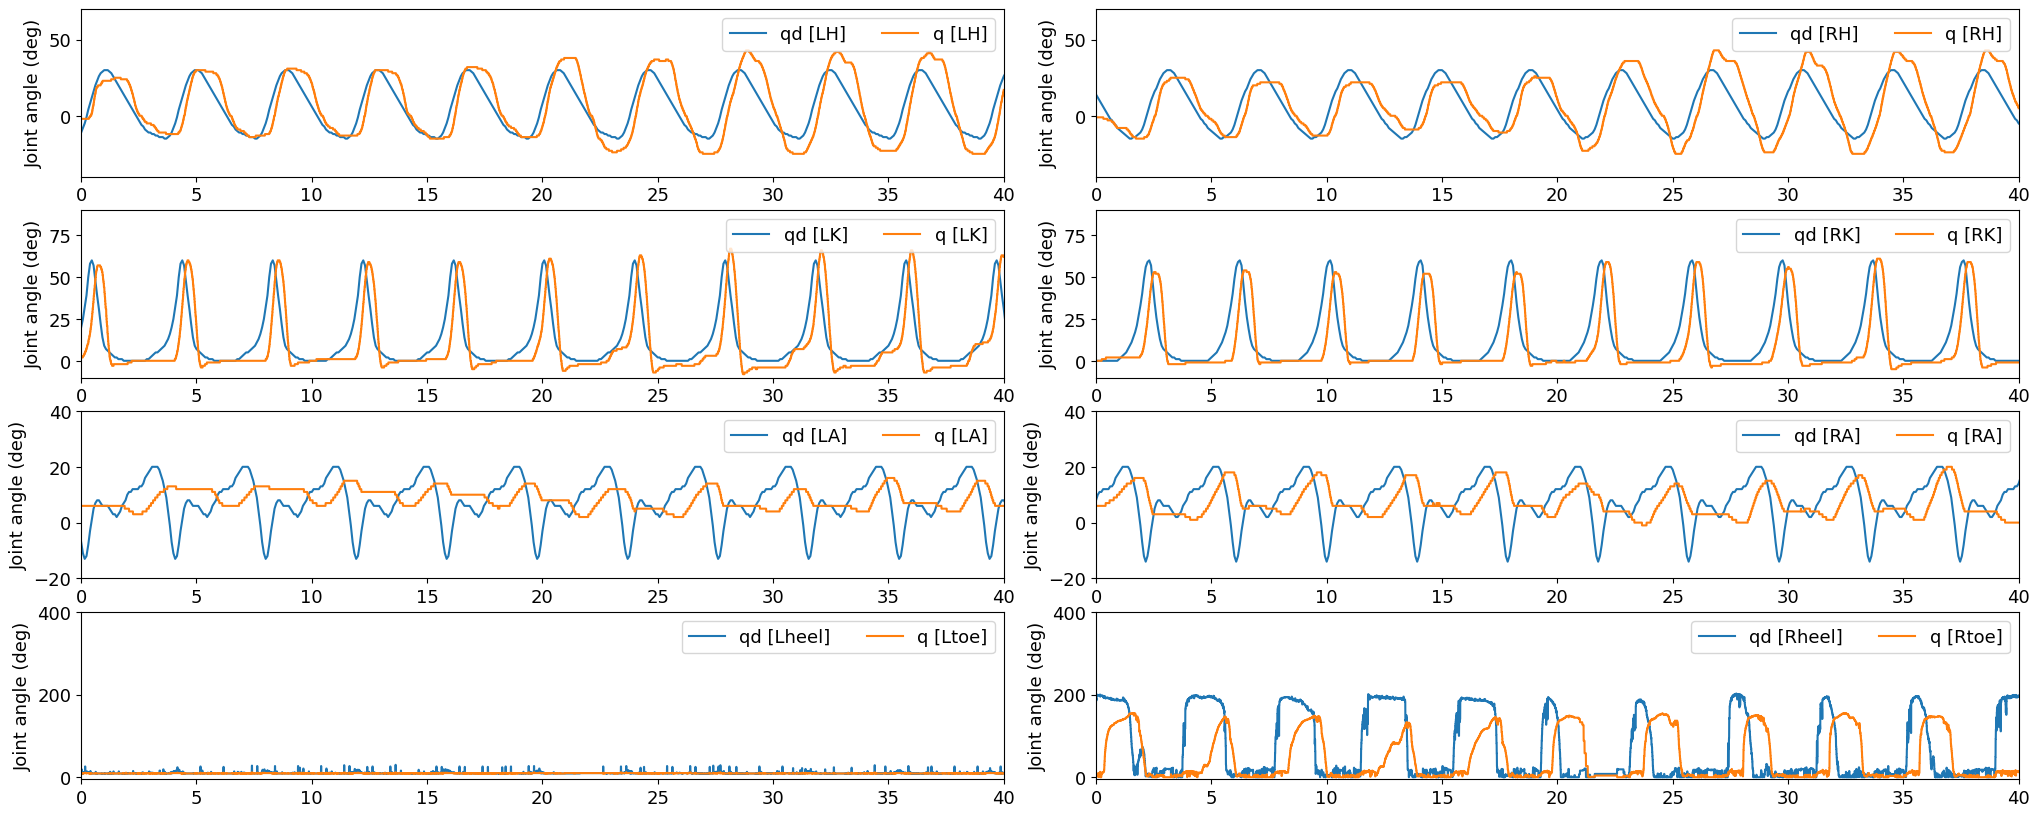

In [ ]:
# import matplotlib.pyplot as plt
# plt.rcParams['font.size'] = 13
# plt.rcParams['xtick.labelsize'] = 13 
# plt.rcParams['ytick.labelsize'] = 13 
# class ScalarFormatterClass(ScalarFormatter):
#    def _set_format(self):
#       self.format = "%1.2f"

# row_num = 4
# col_num = 2
# fig, ax = plt.subplots(row_num, col_num, sharey=False, gridspec_kw={ 'wspace':0.1, 'hspace':0.2}, figsize=(25, 10))

# time_period = 40
# # ===========================================
# #                 
# # ===========================================

# ax[0,1].plot(np.array(sym_joint_cmd_df['ts']), np.array(sym_joint_cmd_df['RH']), label='qd [RH]')
# ax[0,1].plot(np.array(sym_joint_fb_df['ts']), np.array(sym_joint_fb_df['RH']), label='q [RH]')
# ax[0,1].set_ylabel('Joint angle (deg)')
# ax[0,1].legend(ncol=11, loc='upper right')
# ax[0,1].set_xlim(0, time_period)
# ax[0,1].set_ylim(-40, 70)
# # ===========================================
# #                 
# # ===========================================
# ax[1,1].plot(np.array(sym_joint_cmd_df['ts']), np.array(sym_joint_cmd_df['RK']), label='qd [RK]')
# ax[1,1].plot(np.array(sym_joint_fb_df['ts']), np.array(sym_joint_fb_df['RK']), label='q [RK]')
# ax[1,1].set_ylabel('Joint angle (deg)')
# ax[1,1].legend(ncol=11, loc='upper right')
# ax[1,1].set_xlim(0, time_period)
# ax[1,1].set_ylim(-10, 90)

# # ===========================================
# #                 
# # ===========================================

# ax[2,1].plot(np.array(sym_joint_cmd_df['ts']), np.array(sym_joint_cmd_df['RA']), label='qd [RA]')
# ax[2,1].plot(np.array(sym_joint_fb_df['ts']), np.array(sym_joint_fb_df['RA']), label='q [RA]')
# ax[2,1].set_ylabel('Joint angle (deg)')
# ax[2,1].legend(ncol=11, loc='upper right')
# ax[2,1].set_xlim(0, time_period)
# ax[2,1].set_ylim(-20, 40)

# # ===========================================
# #                 
# # ===========================================

# ax[0,0].plot(np.array(sym_joint_cmd_df['ts']), np.array(sym_joint_cmd_df['LH']), label='qd [LH]')
# ax[0,0].plot(np.array(sym_joint_fb_df['ts']), np.array(sym_joint_fb_df['LH']), label='q [LH]')
# ax[0,0].set_ylabel('Joint angle (deg)')
# ax[0,0].legend(ncol=11, loc='upper right')
# ax[0,0].set_xlim(0, time_period)
# ax[0,0].set_ylim(-40, 70)

# # ===========================================
# #                 
# # ===========================================

# ax[1,0].plot(np.array(sym_joint_cmd_df['ts']), np.array(sym_joint_cmd_df['LK']), label='qd [LK]')
# ax[1,0].plot(np.array(sym_joint_fb_df['ts']), np.array(sym_joint_fb_df['LK']), label='q [LK]')
# ax[1,0].set_ylabel('Joint angle (deg)')
# ax[1,0].legend(ncol=11, loc='upper right')
# ax[1,0].set_xlim(0, time_period)
# ax[1,0].set_ylim(-10, 90)

# # ===========================================
# #                 
# # ===========================================
# ax[2,0].plot(np.array(sym_joint_cmd_df['ts']), np.array(sym_joint_cmd_df['LA']), label='qd [LA]')
# ax[2,0].plot(np.array(sym_joint_fb_df['ts']), np.array(sym_joint_fb_df['LA']), label='q [LA]')
# ax[2,0].set_ylabel('Joint angle (deg)')
# ax[2,0].legend(ncol=11, loc='upper right')
# ax[2,0].set_xlim(0, time_period)
# ax[2,0].set_ylim(-20, 40)

# # ===========================================
# #                 
# # ===========================================
# ax[3,1].plot(np.array(sym_foot_force_df['ts']), np.array(sym_foot_force_df['Rheel']), label='qd [Rheel]')
# ax[3,1].plot(np.array(sym_foot_force_df['ts']), np.array(sym_foot_force_df['Rtoe']),  label='q [Rtoe]')
# ax[3,1].set_ylabel('Joint angle (deg)')
# ax[3,1].legend(ncol=11, loc='upper right')
# ax[3,1].set_xlim(0, time_period)
# ax[3,1].set_ylim(-5, 400)

# # ===========================================
# #                 
# # ===========================================
# ax[3,0].plot(np.array(sym_foot_force_df['ts']), np.array(sym_foot_force_df['Lheel']), label='qd [Lheel]')
# ax[3,0].plot(np.array(sym_foot_force_df['ts']), np.array(sym_foot_force_df['Ltoe']), label='q [Ltoe]')
# ax[3,0].set_ylabel('Joint angle (deg)')
# ax[3,0].legend(ncol=11, loc='upper right')
# ax[3,0].set_xlim(0, time_period)
# ax[3,0].set_ylim(-5, 400)



## Gait cycle cut

In [182]:
class GaitCycleDetector:
    def __init__(self, foot_force_threshold=50, max_gait_cycles=15, moving_avg_window=100):
        self.foot_force_threshold = foot_force_threshold
        self.max_gait_cycles = max_gait_cycles  # Maximum number of gait cycles to store
        self.moving_avg_window = moving_avg_window  # Window size for moving average

        self.gait_cycle = []
        self.gait_cycles = []
        self.gait_cycle_phase = ''
        self.gait_cycle_phase_prev = ''
        self.record = False
        self.foot_force_prev = 0
        self.foot_force_window = []  # List to store the last `moving_avg_window` foot forces

    def moving_average(self, new_value):
        """
        Update the moving average with a new foot force value.
        """
        self.foot_force_window.append(new_value)
        # If the window exceeds the maximum size, remove the oldest value
        if len(self.foot_force_window) > self.moving_avg_window:
            self.foot_force_window.pop(0)

        # Return the average of the values in the window
        return sum(self.foot_force_window) / len(self.foot_force_window)
    
    def process_step(self, joint_angle, foot_force_heel, foot_force_toe):
        """
        Process a single step in the gait cycle using foot force and joint angle.
        """
        foot_force_raw = foot_force_heel + foot_force_toe
        foot_force_smoothed = self.moving_average(foot_force_raw)  # Apply moving average smoothing

        # Gait phase detection
        if foot_force_smoothed >= self.foot_force_threshold and self.foot_force_prev < self.foot_force_threshold:
            self.gait_cycle_phase = 'HS'  # Heel strike
        elif foot_force_smoothed < self.foot_force_threshold and self.foot_force_prev >= self.foot_force_threshold:
            self.gait_cycle_phase = 'TO'  # Toe off
        else:
            if self.gait_cycle_phase_prev == 'HS':
                self.gait_cycle_phase = 'ST'  # Stance
            elif self.gait_cycle_phase_prev == 'TO':
                self.gait_cycle_phase = 'SW'  # Swing

        # Record gait cycle
        if self.gait_cycle_phase == 'ST' and self.gait_cycle_phase_prev == 'HS':
            self.record = True
        elif self.gait_cycle_phase == 'HS' and self.gait_cycle_phase_prev == 'SW':
            self.record = False

        if self.record:
            self.gait_cycle.append(joint_angle)  # Record joint angle
        elif not self.record:
            if len(self.gait_cycle) > 0:
                self.gait_cycles.append(self.gait_cycle)  # Save completed gait cycle
                self.gait_cycle = []  # Clear the temporary gait cycle

                # Ensure gait cycles do not exceed the maximum limit
                if len(self.gait_cycles) > self.max_gait_cycles:
                    self.gait_cycles.pop(0)  # Remove the oldest gait cycle

        # Update previous states
        self.gait_cycle_phase_prev = self.gait_cycle_phase
        self.foot_force_prev = foot_force_smoothed

    def get_latest_gait_cycle(self):
        """
        Retrieve the latest completed gait cycle, if available.
        """
        if self.gait_cycles:
            return self.gait_cycles[-1]  # Return the last detected gait cycle
        return None  # Return None if no gait cycle is available

    def get_gait_cycles(self):
        """
        Retrieve the detected gait cycles.
        """
        gait_cycles = self.gait_cycles
        return gait_cycles
    
    def get_number_gait_cycles(self):
        """
        Retrieve number of the detected gait cycles in buffer.
        """
        num_gait_cycles = len(self.gait_cycles)
        return num_gait_cycles




In [183]:
gait_cycle_detector = GaitCycleDetector()

for joint_angle, foot_force_heel, foot_force_toe in zip(sym_joint_fb_df['RH'], sym_foot_force_df['Rheel'], sym_foot_force_df['Rtoe']):
    gait_cycle_detector.process_step(joint_angle, foot_force_heel, foot_force_toe)


print('number of gait cycle:', gait_cycle_detector.get_number_gait_cycles())

number of gait cycle: 10


In [185]:
fig = go.Figure()
fig = make_subplots(rows=2, cols=1, shared_xaxes=False)

gait_cycles = gait_cycle_detector.get_gait_cycles()
latest_gait_cycles = gait_cycle_detector.get_latest_gait_cycle()

for i in range(len(gait_cycle_detector.get_gait_cycles())):
    fig.add_trace(go.Scatter( y=gait_cycles[i], mode='lines', name=f'gait cycle {i+1}'), row=1, col=1)

fig.add_trace(go.Scatter( y=latest_gait_cycles, mode='lines', name=f'latest gait cycle', line=dict(color='blue')), row=2, col=1)


fig.update_layout(height=300, width=650, title="Gait cycles")
fig.update_layout(margin=dict(l=10, r=10, t=40, b=10))  # Reduce margins
fig.show()

## DMPs learn path

In [ ]:
path1 = np.array(stair_joint_fb_df['RH'])
path2 = np.array(stair_joint_fb_df['RK'])


dmp = DMPs_discrete(n_dmps=2, n_bfs=500)
dmp.imitate_path(y_des=np.array([path1, path2]))
y_track, dy_track, ddy_track = dmp.rollout(tau=0.005)

x_track = dmp.cs.rollout()
psi_values = dmp.gen_psi(x_track)
weighted_kernels = psi_values @ dmp.w.T


# dmp = DMPs_rhythmic(n_dmps=2, n_bfs=10000)
# dmp.imitate_path(y_des=np.array([path1, path2]))
# y_track, dy_track, ddy_track = dmp.rollout(tau=0.015)

In [47]:
fig = go.Figure()
fig = make_subplots(rows=2, cols=1, shared_xaxes=False)

fig.add_trace(go.Scatter( y=path1[:], mode='lines', name='Hip traj. [based line]', line=dict(color='red', dash='dot')), row=1, col=1)
fig.add_trace(go.Scatter( y=path2[:], mode='lines', name='Knee traj. [based line]', line=dict(color='blue', dash='dot')), row=2, col=1)

fig.add_trace(go.Scatter( y=y_track[:, 0], mode='lines', name='Hip traj. [DMP]', line=dict(color='red' )), row=1, col=1)
fig.add_trace(go.Scatter( y=y_track[:, 1], mode='lines', name='Knee traj. [DMP]', line=dict(color='blue')), row=2, col=1)



fig.update_layout(height=500, width=1300, title="DMP imitate Hip&Knee traj.")
fig.update_layout(margin=dict(l=10, r=10, t=40, b=10))  # Reduce margins
fig.show()

In [31]:
fig = go.Figure()
fig = make_subplots(rows=2, cols=1, shared_xaxes=False)

for i in range(dmp.n_bfs):
    fig.add_trace(go.Scatter(x=x_track, y=psi_values[:, i], mode='lines', name=f"Basis {i+1}"), row=1, col=1)

for i in range(dmp.n_dmps):
    fig.add_trace(go.Scatter(x=x_track, y=weighted_kernels[:, i], mode='lines', name=f"Weighted Kernel {i+1}"), row=2, col=1)


fig.update_layout(height=500, width=1300, title="Kernals")
fig.update_layout(margin=dict(l=10, r=10, t=40, b=10))  # Reduce margins
fig.show()